In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import time

import programs.NN as NN
import programs.visualize as vis
import programs.misc as misc

from programs.Poisson_Convection import *
from programs.misc import *

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print(device)

cuda:0


In [3]:
# Ширина трещины
w = 1.

# Вязкость
mu0 = 0.01

# Максимальная концентрация проппанта
cmax = 1.

# Концентрация входящего проппанта в первый момент времени
c1 = 0.85

# Концентрация входящего проппанта во второй момент времени
c2 = 0.0

# Интервалы смены концентрации
transitional_times = [0.5]

# Скорость потока
u_in = 1.

# Длина интервала перфорации
chi = 0.5

# Степень в вязкости
beta = -2.5

# Число точек для ГУ (возводится в квадрат)
BC_points = 16

# Число точек для НУ (возводится в квадрат)
IC_points = 16

# Число точек коллокации (возводится в куб)
PDE_points = 16

# Границы для x,y,t
x_min, x_max, y_min, y_max, t_min, t_max = 0.0, 1.0, 0.0, 1.0, 0.0, 1.0
boundaries = [x_min, x_max, y_min, y_max, t_min, t_max]

# Массивы условий
cond = u_in * -12
mu1 = cond * misc.viscosity(mu0,c1,cmax,beta)
mu2 = cond * misc.viscosity(mu0,c2,cmax,beta)
c_condition = [c1, c2]
print (cond*mu0, cond*misc.viscosity(mu0,np.array(c_condition),cmax,beta))
print (misc.compare_viscosity(0.3,0,0.66,beta))

-0.12 [-13.77060745  -0.12      ]
4.550965958152553


In [7]:
net = Poisson_Convection({'w':w,
                          'mu0':mu0,
                          'cmax':cmax,
                          'u_in':u_in,
                          'chi':chi,
                          'times':transitional_times,
                          'size':boundaries,
                          'c_cond':c_condition,
                          'PDE_points':PDE_points,
                          'BC_points':BC_points,
                          'IC_points':IC_points,
                          'beta':beta
                          })
net.model.apply(NN.Net.init_weights)

Net(
  (layers): Sequential(
    (input): Linear(in_features=3, out_features=48, bias=True)
    (input_activation): Sin()
    (hidden_0): Linear(in_features=48, out_features=48, bias=True)
    (activation_0): Sin()
    (hidden_1): Linear(in_features=48, out_features=48, bias=True)
    (activation_1): Sin()
    (hidden_2): Linear(in_features=48, out_features=48, bias=True)
    (activation_2): Sin()
    (hidden_3): Linear(in_features=48, out_features=48, bias=True)
    (activation_3): Sin()
    (output): Linear(in_features=48, out_features=3, bias=True)
  )
)

In [8]:
net.load("data/big2")
# net.save("data/big2")
# vars(net)

# for i in range(len(net.c_IC)):
    # print (i+1, round(net.c_IC[i].item(),4), round(net.x_IC[i].item(),4), round(net.y_IC[i].item(),4), round(net.t_IC[i].item(),4))

# for i in range(len(net.c)):
    # print (i+1, net.c[i].item(), net.p[i].item(), round(net.x[i].item(), 4), round(net.y[i].item(),4))#, round(net.t[i].item(),4))

# for i in range(len(net.X)):
    # print (i+1,  round(net.X[i].item(), 4), round(net.Y[i].item(),4), round(net.T[i].item(),4))
# for i in range(len(net.c)):
    # print (i+1, net.X[i].item(),net.x_IC[i].item())

In [ ]:
net.weights = [1,1,1,1,1,1]
net.Adam_epochs = 1000
start_time = time.time()
net.update()
net.train()
net.save('big3')
# net.save("data/0.6-0.2-0.0")
end_time = time.time()
elapsed_time = end_time - start_time

In [ ]:
print('Elapsed time: ', elapsed_time)

0.00818859227001667 101001


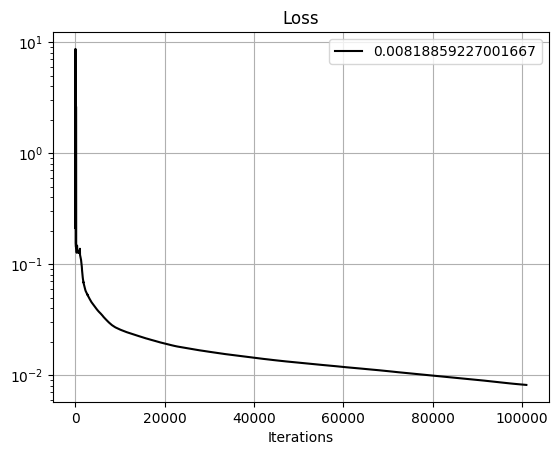

In [9]:
print (net.losses[-1], len(net.losses))
vis.plot_loss(net.losses)
plt.legend()
plt.savefig("gifs/losses")
# plt.ylim(1e-5,1e2)

In [21]:
net.eval_()

try:
  del u,c,p,u_x,u_y
except NameError:
  None

Nx = 71
Ny = 71
Nt = 101

t = torch.linspace(net.size[0], net.size[1], Nt)
x = torch.linspace(net.size[2], net.size[3], Nx)
y = torch.linspace(net.size[4], net.size[5], Ny)

mesh_XYT = torch.stack(torch.meshgrid(x,y,t, indexing='ij')).reshape(3, -1).T

X = torch.autograd.Variable(mesh_XYT[:,0], requires_grad=True)#.reshape(-1,1)
Y = torch.autograd.Variable(mesh_XYT[:,1], requires_grad=True)#.reshape(-1,1)
T = torch.autograd.Variable(mesh_XYT[:,2], requires_grad=True)#.reshape(-1,1)

n = net.model([X,Y,T], net.transform)
print (n.shape)
mu = net.mu0*(1 - n[:,0]/net.cmax)**(net.beta)
ux = -net.w**2 * n[:,1] / 12 / mu 
uy = -net.w**2 * n[:,2] / 12 / mu

cc = misc.derivative(n[:,0], T) + misc.derivative(n[:,0]*ux, X) + misc.derivative(n[:,0]*uy, Y)
cc = cc.reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)

u = misc.derivative(ux,X) + misc.derivative(uy,Y)
u = u.reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)

c    = n[:,0].reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)
px   = n[:,1].reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)
py   = n[:,2].reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)

mu   = mu.reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)
ux   = ux.reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)
uy   = uy.reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)

del X,Y,T,mesh_XYT,n

torch.Size([509141, 3])


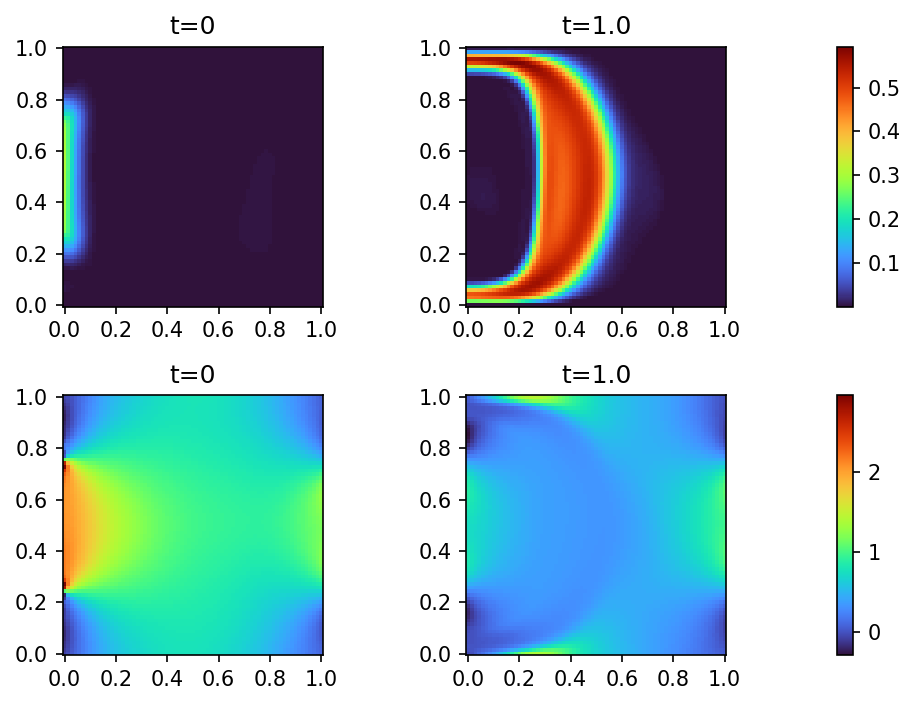

In [22]:
vis.plot_results([c[0],c[-1],ux[0],ux[-1]],[x_min, x_max, y_min, y_max], t_max, Nx, Ny)

([<matplotlib.axis.XTick at 0x240a4494150>,
 [Text(0.0, 0, '0.00'),
  Text(0.25, 0, '0.25'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1.00')])

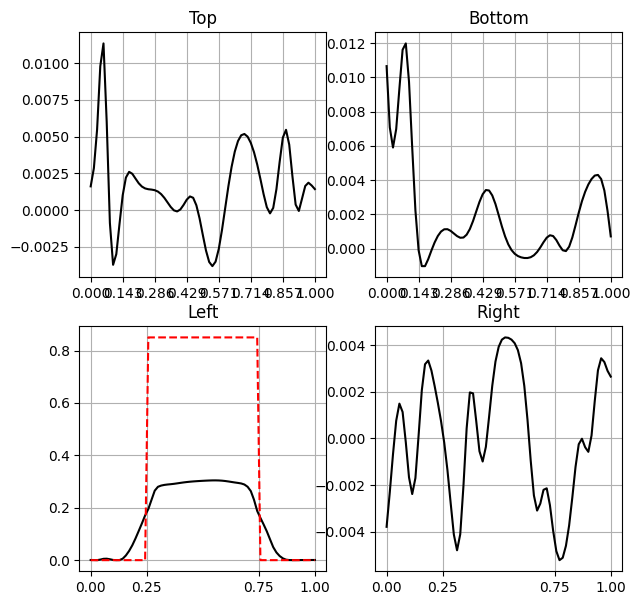

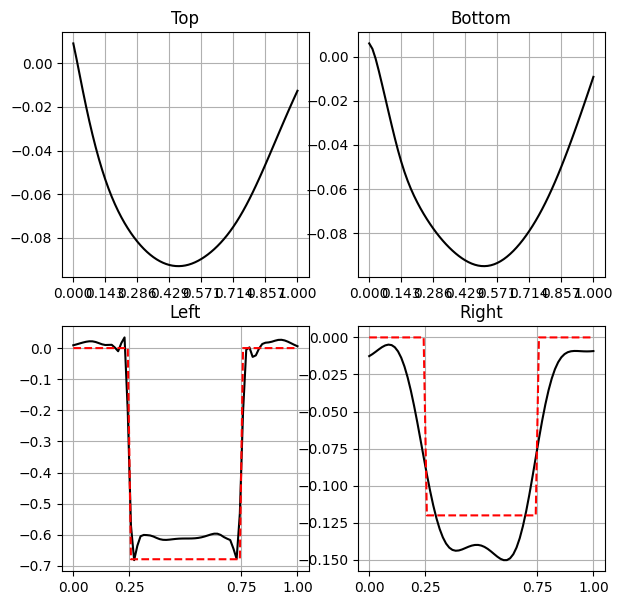

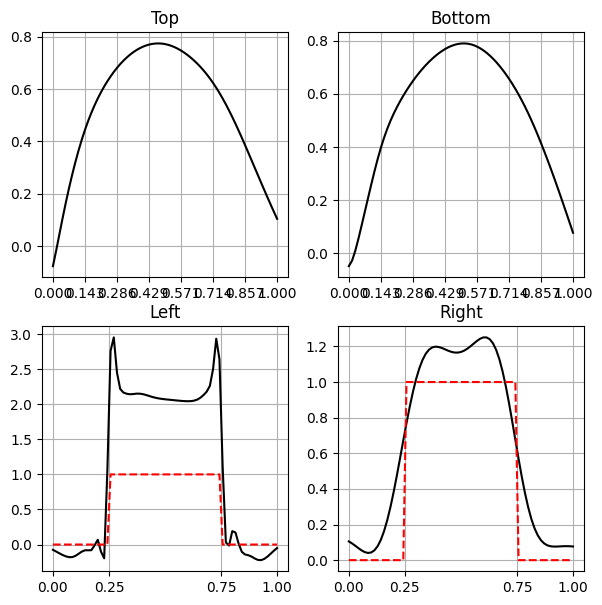

In [23]:
t = np.linspace(t_min, t_max, Nt)
x = np.linspace(x_min, x_max, Nx)
y = np.linspace(y_min, y_max, Ny)

i = 0
vis.plot_BC(c[i], x, y, 1/(Nx-1), 1/(Ny-1), [1,1,0,1])
plt.subplot(223)
plt.plot(y, np.where(np.abs(y - np.max(y) / 2).round(4) <= chi / 2, c1, 0), c='red', ls='--')
# plt.plot(y, np.where(np.abs(y - np.max(y) / 2) <= chi / 2, c2, 0), c='red', ls='--')
plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])
plt.subplot(224)
plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])

vis.plot_BC(px[i], x, y, 1/(Nx-1), 1/(Ny-1), [0,0,0,0])
plt.subplot(223)
plt.plot(y, np.where(np.abs(y - np.max(y) / 2).round(4) <= chi / 2, net.p.unique()[0].item(), 0), c='red', ls='--')
plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])
plt.subplot(224)
plt.plot(y, np.where(np.abs(y - np.max(y) / 2).round(4) <= chi / 2, net.p.unique()[1].item(), 0), c='red', ls='--')
plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])

vis.plot_BC(ux[i], x, y, 1/(Nx-1), 1/(Ny-1), [0,0,0,0])
plt.subplot(223)
plt.plot(y, np.where(np.abs(y - np.max(y) / 2).round(4) <= chi / 2, net.u_in, 0), c='red', ls='--')
plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])
plt.subplot(224)
plt.plot(y, np.where(np.abs(y - np.max(y) / 2).round(4) <= chi / 2, net.u_in, 0), c='red', ls='--')
plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])

0.0


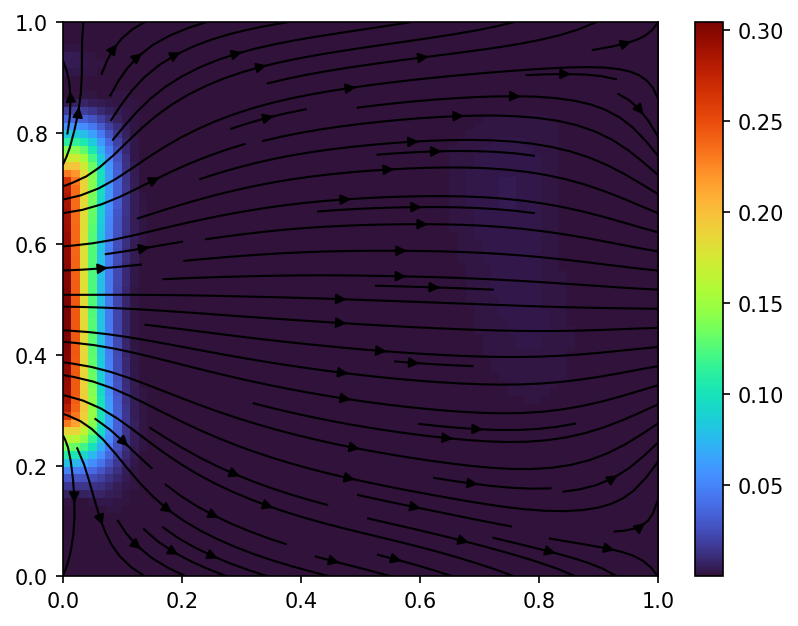

In [25]:
mesh_x, mesh_y = np.meshgrid(x,y)
# vis.plot(c[0], limits=[0,1,0,1])
fig, ax = plt.subplots()
fig.dpi = 150
ax1 = ax.twinx()
i = 0
print(t[i]) 
# imsh = ax.imshow(np.where(np.abs((u_xx+u_yy)[0])<=0.01, np.nan, (u_xx+u_yy)[0]), cmap = 'turbo', extent = [0, 1, 0, 1], interpolation='none', aspect='auto')
imsh = ax.imshow(c[i], cmap = 'turbo', extent = [0, 1, 0, 1], interpolation='none', aspect='auto')
# ax.set_aspect('equal', 'datalim')
ax1.axis('off')
# a.set_aspect('equal', 'box')
strm = ax1.streamplot(mesh_x, mesh_y, ux[i], uy[i], linewidth=1, color='black')
# fig.colorbar(strm.lines)
# imsh.set_clim(-0.01,0)
plt.colorbar(imsh)

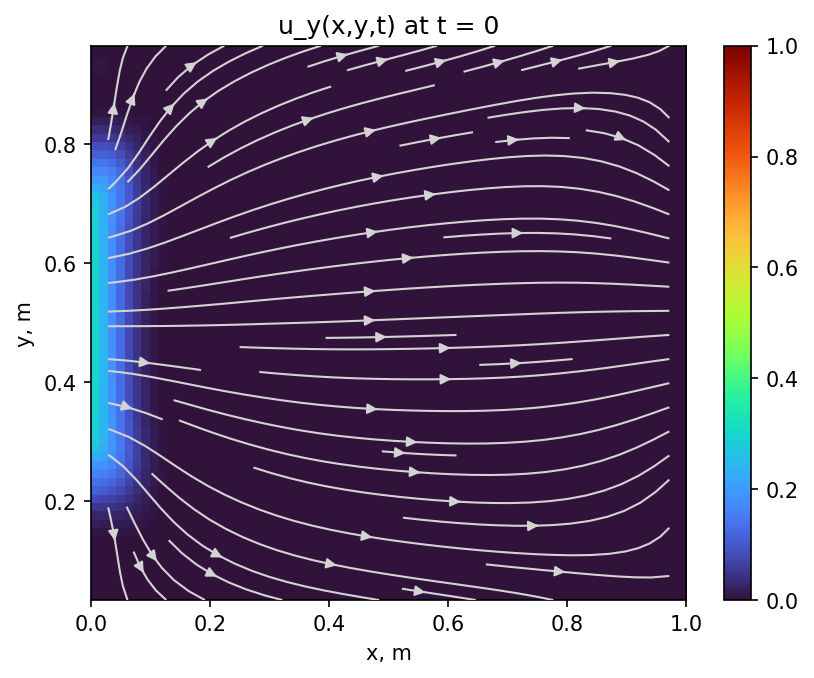

In [ ]:
vis.anim_result(c,
                t_max/Nt,
                clims=[0,1],
                streamplot_data=[mesh_x[2:-2,2:-2],mesh_y[2:-2,2:-2],ux[:,2:-2,2:-2],uy[:,2:-2,2:-2]],
                name='serv_test',
                title='u_y(x,y,t)',
                colour='turbo',
                path='gifs',
                savetogif=True,
                showMe=True,
                )